In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Covid Data.csv')
print(df.shape)
print(df.info())
print(df.head())
print("Missing Values in Training Data:\n", df.isnull().sum())


(1048575, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   DATE_DIED             1048575 non-null  object
 5   INTUBED               1048575 non-null  int64 
 6   PNEUMONIA             1048575 non-null  int64 
 7   AGE                   1048575 non-null  int64 
 8   PREGNANT              1048575 non-null  int64 
 9   DIABETES              1048575 non-null  int64 
 10  COPD                  1048575 non-null  int64 
 11  ASTHMA                1048575 non-null  int64 
 12  INMSUPR               1048575 non-null  int64 
 13  HIPERTENSION          1048575 non-null  int64 
 14  OTHER_DISEASE         1048575 non-nu

In [3]:
# Duplicate Removal
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

if num_duplicates > 0:
    df = df.drop_duplicates()
    print(f"Duplicates removed. New dataset shape: {df.shape}")

Number of duplicate rows: 812049
Duplicates removed. New dataset shape: (236526, 21)


In [4]:

# Replace invalid date formats with a default value (e.g., '1111-11-11')
df['DATE_DIED'] = df['DATE_DIED'].replace({'9999-99-99': '1111-11-11'})

# Convert the DATE_DIED column to datetime format, handling the replacement
df['DATE_DIED'] = pd.to_datetime(df['DATE_DIED'], dayfirst=True, errors='coerce')

# Check how many dates are coerced to NaT after replacement
num_na_dates = df['DATE_DIED'].isna().sum()
print(f"Number of rows with dates coerced to NaT: {num_na_dates}")

# Filter rows with valid DATE_DIED (non-NaT)
df_valid_dates = df[df['DATE_DIED'].notna()]
print(f"Rows with valid dates: {len(df_valid_dates)}")

# Create a time series of daily deaths from valid rows
daily_deaths = df_valid_dates.groupby('DATE_DIED').size().reset_index(name='deaths')
daily_deaths = daily_deaths.set_index('DATE_DIED')

# Fill in missing dates with zero deaths (in case there are gaps in date coverage)
date_range = pd.date_range(start=daily_deaths.index.min(), end=daily_deaths.index.max())
daily_deaths = daily_deaths.reindex(date_range, fill_value=0)

Number of rows with dates coerced to NaT: 160561
Rows with valid dates: 75965


In [5]:
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

outliers_age = detect_outliers(df, 'AGE')
print(f"Number of outliers in AGE: {len(outliers_age)}")

df_cleaned = df[~df.index.isin(outliers_age.index)]
print(f"New dataset shape after removing AGE outliers: {df_cleaned.shape}")

Number of outliers in AGE: 37
New dataset shape after removing AGE outliers: (236489, 21)


In [6]:
# Update daily deaths with the cleaned dataframe
daily_deaths = df_cleaned.groupby('DATE_DIED').size().reset_index(name='deaths')
daily_deaths = daily_deaths.set_index('DATE_DIED')
daily_deaths = daily_deaths.reindex(date_range, fill_value=0)

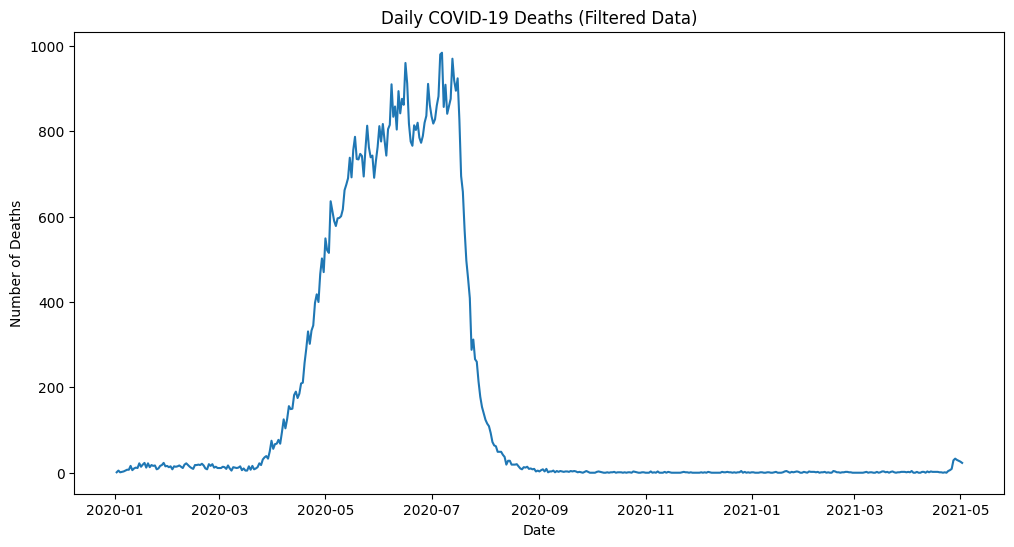

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(daily_deaths)
plt.title('Daily COVID-19 Deaths (Filtered Data)')
plt.xlabel('Date')
plt.ylabel('Number of Deaths')
plt.savefig('Daily_Deaths_Filtered.png', bbox_inches='tight')
plt.show()
plt.close()

In [8]:
train_size = int(0.8 * len(daily_deaths))
train = daily_deaths[:train_size]
test = daily_deaths[train_size:]

print(f"Training data from {train.index[0]} to {train.index[-1]}")
print(f"Testing data from {test.index[0]} to {test.index[-1]}")

Training data from 2020-01-02 00:00:00 to 2021-01-24 00:00:00
Testing data from 2021-01-25 00:00:00 to 2021-05-02 00:00:00


In [9]:
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))  # Adjust parameters as needed
results = model.fit(disp=False)

# Make predictions
sarimax_prediction = results.get_forecast(steps=len(test))

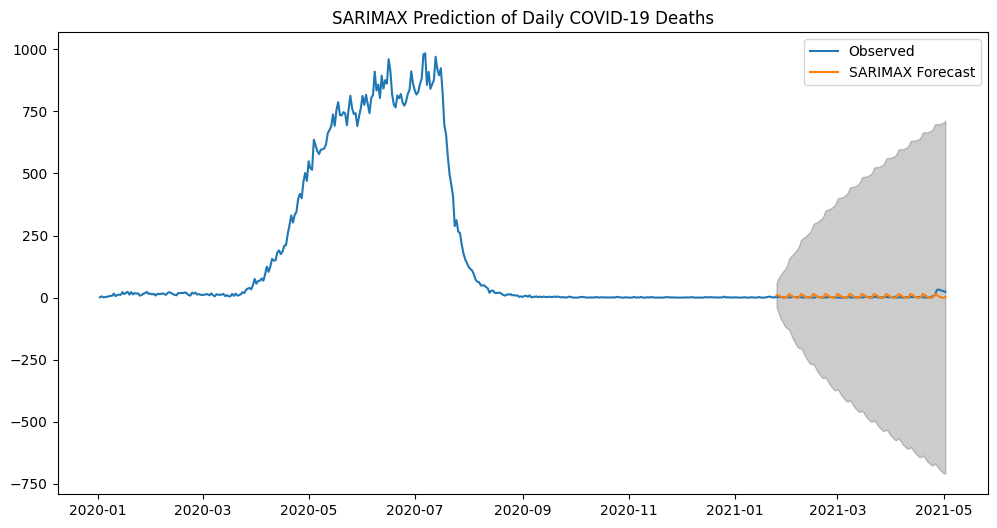

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(daily_deaths, label='Observed')
plt.plot(sarimax_prediction.predicted_mean, label='SARIMAX Forecast')
plt.fill_between(sarimax_prediction.conf_int().index,
                 sarimax_prediction.conf_int().iloc[:, 0],
                 sarimax_prediction.conf_int().iloc[:, 1], color='k', alpha=.2)
plt.title('SARIMAX Prediction of Daily COVID-19 Deaths')
plt.legend()
plt.savefig('SARIMAX_Prediction.png', bbox_inches='tight')
plt.show()
plt.close()


In [11]:
# Evaluate the model
mae = mean_absolute_error(test, sarimax_prediction.predicted_mean)
print(f'SARIMAX MAE: {mae}')

# Print model summary
print(results.summary())

SARIMAX MAE: 6.074675702999729
                                     SARIMAX Results                                     
Dep. Variable:                            deaths   No. Observations:                  389
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -1785.896
Date:                           Thu, 26 Sep 2024   AIC                           3581.793
Time:                                   20:31:41   BIC                           3601.507
Sample:                               01-02-2020   HQIC                          3589.614
                                    - 01-24-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8440      0.049    -17.137      0.000      -0.941      -0.747
ma.L1       

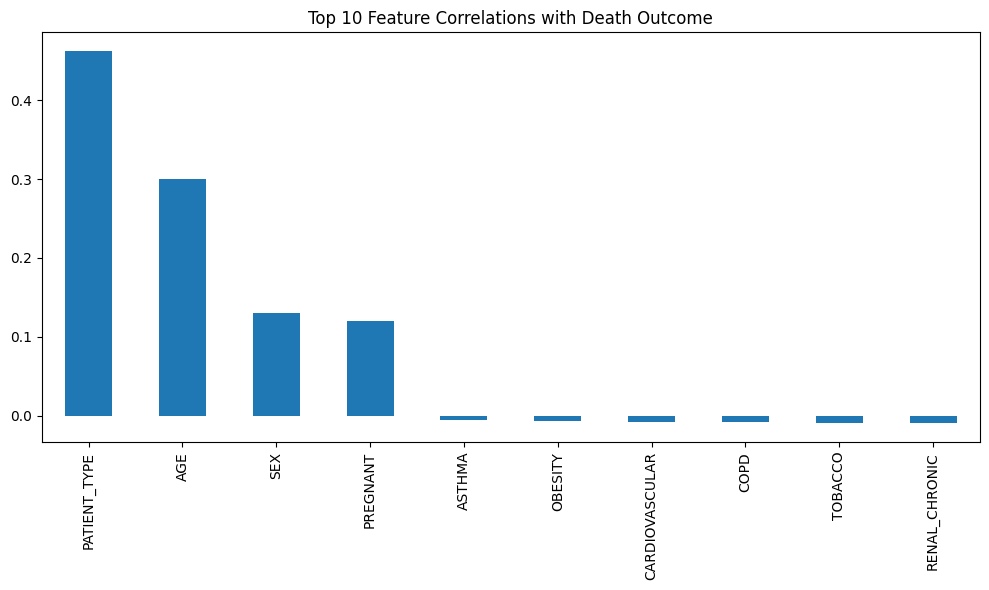

In [12]:
# Feature importance analysis (using correlation with death outcome)
df['DEATH'] = df['DATE_DIED'].notna().astype(int)
feature_cols = ['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'INTUBED', 'PNEUMONIA', 'AGE', 
                'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 
                'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'ICU']
correlations = df[feature_cols + ['DEATH']].corr()['DEATH'].sort_values(ascending=False)
plt.figure(figsize=(10, 6))
correlations.drop('DEATH').nlargest(10).plot(kind='bar')
plt.title('Top 10 Feature Correlations with Death Outcome')
plt.tight_layout()
plt.savefig('Feature_Correlations.png', bbox_inches='tight')
plt.show()
plt.close()



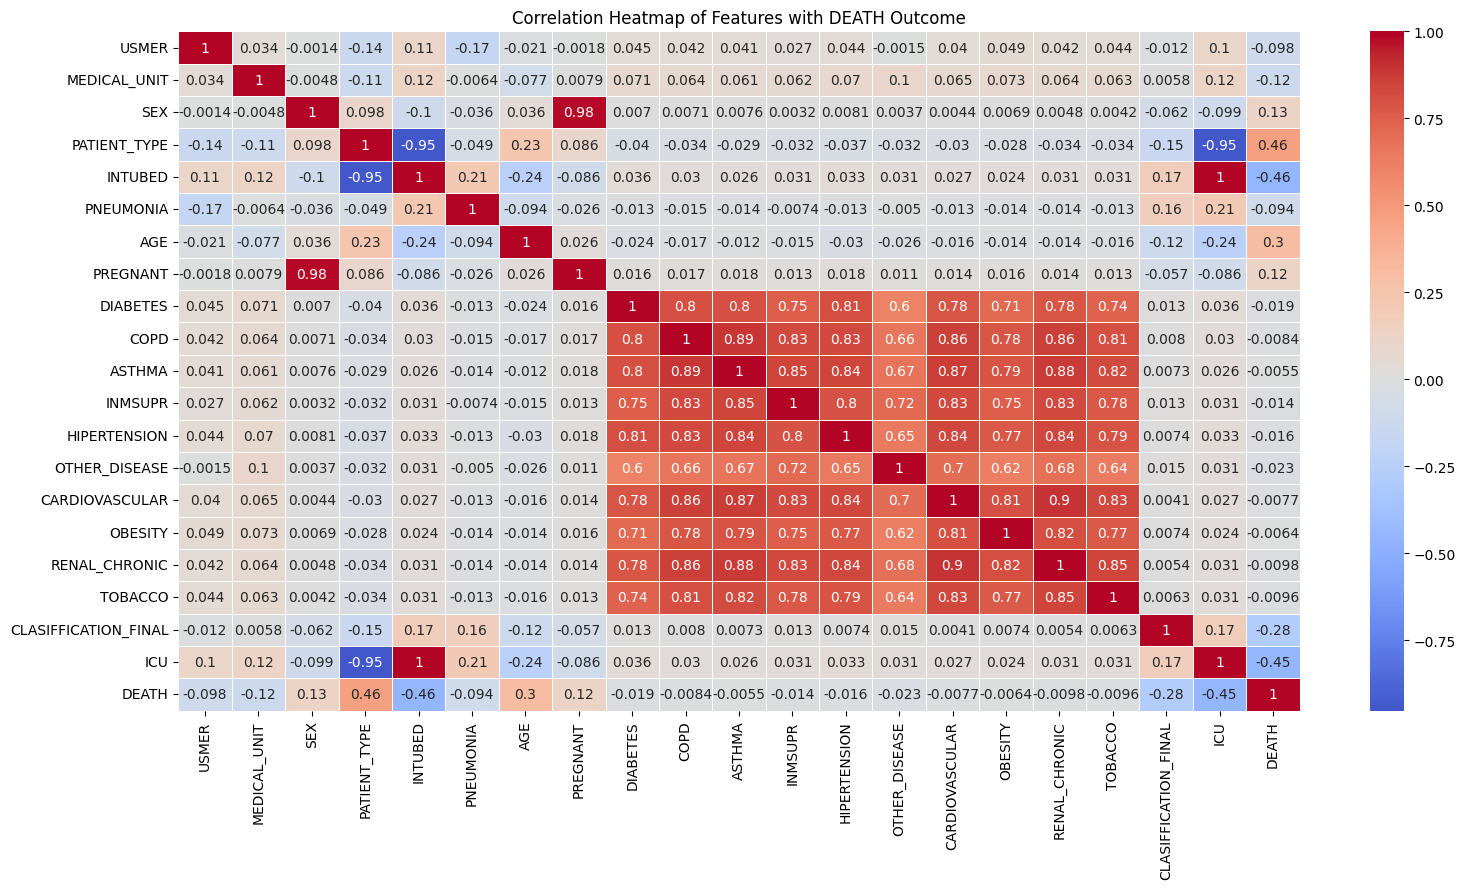

In [13]:
correlation_matrix = df[feature_cols + ['DEATH']].corr()

# Set up the figure size
plt.figure(figsize=(16, 9))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)

# Add title and labels
plt.title('Correlation Heatmap of Features with DEATH Outcome')
plt.tight_layout()

# Save the heatmap
plt.savefig('Feature_Correlation_Heatmap.png', bbox_inches='tight')

# Show the heatmap
plt.show()

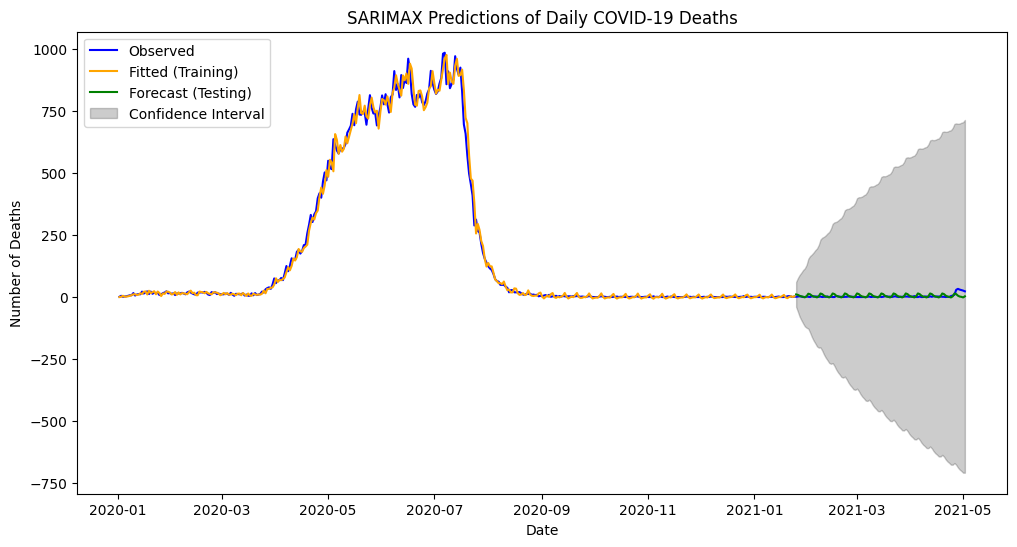

In [14]:
# Forecast the entire dataset (both train and test)
full_forecast = results.get_forecast(steps=len(test))

# Create a DataFrame for predicted values
predicted_values = pd.DataFrame({
    'predicted': results.fittedvalues,
    'forecast': full_forecast.predicted_mean
})

# Combine the actual and predicted values for visualization
full_series = daily_deaths.copy()
full_series['predicted'] = predicted_values['predicted']
full_series['forecast'] = predicted_values['forecast'].reindex(full_series.index)

# Visualize the actual data and predictions
plt.figure(figsize=(12, 6))
plt.plot(full_series['deaths'], label='Observed', color='blue')
plt.plot(full_series['predicted'], label='Fitted (Training)', color='orange')
plt.plot(full_series['forecast'], label='Forecast (Testing)', color='green')

# Add confidence intervals for the forecast
plt.fill_between(full_forecast.conf_int().index,
                 full_forecast.conf_int().iloc[:, 0],
                 full_forecast.conf_int().iloc[:, 1], color='k', alpha=0.2, label='Confidence Interval')

# Add labels and title
plt.title('SARIMAX Predictions of Daily COVID-19 Deaths')
plt.xlabel('Date')
plt.ylabel('Number of Deaths')
plt.legend()

# Save or display the plot
plt.savefig('Full_SARIMAX_Predictions.png', bbox_inches='tight')
plt.show()
